In [74]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy.optimize import curve_fit#Used for continuum removal and also polynomial fit
from scipy.signal import find_peaks#Used in interference peak removal

In [213]:
spec_list=glob('C:/Users/gjc10/Desktop/GalData/Radio_Rot_Curve_Data_2019/*')#The LSR correction file has been removed from this folder
print(spec_list)

['C:/Users/gjc10/Desktop/GalData/Radio_Rot_Curve_Data_2019\\10.txt', 'C:/Users/gjc10/Desktop/GalData/Radio_Rot_Curve_Data_2019\\12.txt', 'C:/Users/gjc10/Desktop/GalData/Radio_Rot_Curve_Data_2019\\14.txt', 'C:/Users/gjc10/Desktop/GalData/Radio_Rot_Curve_Data_2019\\16.txt', 'C:/Users/gjc10/Desktop/GalData/Radio_Rot_Curve_Data_2019\\18.txt', 'C:/Users/gjc10/Desktop/GalData/Radio_Rot_Curve_Data_2019\\20.txt', 'C:/Users/gjc10/Desktop/GalData/Radio_Rot_Curve_Data_2019\\22.txt', 'C:/Users/gjc10/Desktop/GalData/Radio_Rot_Curve_Data_2019\\24.txt', 'C:/Users/gjc10/Desktop/GalData/Radio_Rot_Curve_Data_2019\\26.txt', 'C:/Users/gjc10/Desktop/GalData/Radio_Rot_Curve_Data_2019\\28.txt', 'C:/Users/gjc10/Desktop/GalData/Radio_Rot_Curve_Data_2019\\30.txt', 'C:/Users/gjc10/Desktop/GalData/Radio_Rot_Curve_Data_2019\\32.txt', 'C:/Users/gjc10/Desktop/GalData/Radio_Rot_Curve_Data_2019\\34.txt', 'C:/Users/gjc10/Desktop/GalData/Radio_Rot_Curve_Data_2019\\36.txt', 'C:/Users/gjc10/Desktop/GalData/Radio_Rot_Curve

In [35]:
#General test
with open(spec_list[3]) as f:
    lines=f.readlines()
    print('l=',float(lines[0].split('=')[1].split(',')[0]))
    print('LSR_Corr=',float(lines[3].split(' ')[-2]))
    print(lines[6].split(' '))
    print([float(el) for el in lines[6].split(' ')])

l= 16.0
LSR_Corr= -42.1025
['1.414400000000000091e+03', '1.163600000000000000e+05', '1.424400000000000091e+03', '1.202710000000000000e+05', '1.333900000000000000e+05\n']
[1414.4, 116360.0, 1424.4, 120271.0, 133390.0]


In [270]:
def Opener(spec_file):#Obtains all necessary info regarding headers and spectra given a file path
    with open(spec_file) as f:#This method automatically closes the file upon completion
        lines=f.readlines()#Provides list with each line being a string as an element
        l=float(lines[0].split('=')[1].split(',')[0])#gets l, uses split to isolate and then converted to float
        LSR_Corr=float(lines[3].split(' ')[-2])#same idea
        OnFreq=[]
        On=[]
        OffFreq=[]
        Off=[]
        Cal=[]
        for line in lines[6:]:#Reads the actual spectra, splitting into the elements using the space delimeter and adding them to the correct lists
            nums=[float(el) for el in line.split(' ')]
            OnFreq.append(nums[0])
            On.append(nums[1])
            OffFreq.append(nums[2])
            Off.append(nums[3])
            Cal.append(nums[4])
    return l,LSR_Corr,OnFreq,On,OffFreq,Off,Cal
def bkg_fit(x,a,b):#Used for continuum removal, linear works good enough so no need for splines etc
    return a*x+b
def Spec2vel(freq,lsr_corr):#Doppler correction
    c=299792#in km/s
    f_0=1420.406#rest freq
    vels=[]
    for f in freq:
        v=((f_0-f)/f_0)*c-(220+lsr_corr)
        vels.append(v)
    return vels
def Processor(OnFreq,On,Off,Cal,lsr_corr):
    #This function calibrates, removes continuum, removes peaks and then doppler corrects
    #Calibration:
    T_sys=(np.sum(Off)/np.sum(np.asarray(Cal)-np.asarray(Off)))*20
    calibrated=(np.asarray(On)/np.asarray(Off))*T_sys
    #Continuum Removal:
    popt,pcov=curve_fit(bkg_fit,OnFreq,calibrated)#Continuum fit
    bkg=np.asarray([bkg_fit(el,popt[0],popt[1]) for el in OnFreq])
    bkg_subtracted=calibrated-bkg
    #Peak removal:
    filtered_freq=[el for el in OnFreq]#Copies of original arrays
    filtered_spec=[el for el in bkg_subtracted]
    i=1#This exists so the while loop repeats until it finds no peaks, necessary as only removes centre cell of interference peak
    while i>0:
        peak_inds=find_peaks(np.abs(filtered_spec),threshold=np.std(filtered_spec),distance=10)[0]#absolute value to try get rid of downwards peaks too
        #Interestingly the downwards peaks appeared to be removed less often as can be seen later
        for el in peak_inds:
            del filtered_freq[el]
            del filtered_spec[el]
        i=len(peak_inds)
    #Doppler Correction:
    vels=Spec2vel(filtered_freq,lsr_corr)
    
    return vels,filtered_spec
def V_max_finder(vels,filtered_spec,thres=1):#Finds v_max given a spectrum and a threshold
    #This function effectively works by finding at what point the flux returns to the normal value expected after the peak
    threshold=np.mean(filtered_spec)+thres*np.std(filtered_spec)#This is the line that defines at what point the flux has returned to the remaining continuum
    possibles=[]#Needed due to there being multiple peaks and noise
    for num,val in enumerate(filtered_spec[1:]):
        if val>threshold and filtered_spec[num-1]<threshold:#When does it cross the threshold?
            possibles.append(np.mean([vels[num-1],vels[num]]))
    return np.max(possibles)#Max to get the correct point due to thre being multiple as explained previously
def Results_finder(l,vmax,lsr_corr):#Calculates the end results that are plotted
    R=8.5*np.sin((l*np.pi)/180)
    V=vmax+(220)*np.sin((l*np.pi)/180)+220#This addition of the LSR was simply added to obtain values close to that seen in example and literature
    return R,V

    
    

In [274]:
data=Opener(spec_list[1])#Test

12.0


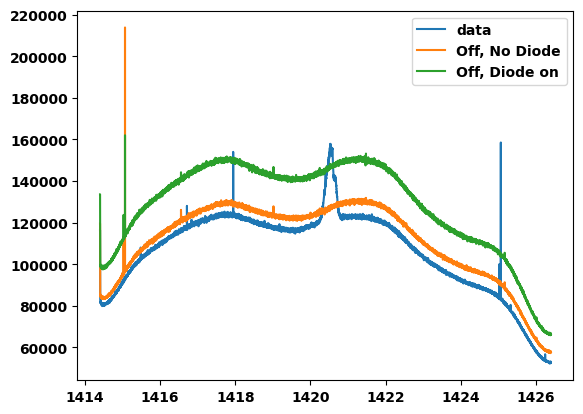

In [275]:
print(data[0])
#Test plot
plt.plot(data[2],data[3],label='data')
plt.plot(data[2],data[5],label='Off, No Diode')
plt.plot(data[2],data[6],label='Off, Diode on')
plt.legend()

In [276]:
T_sys=(np.sum(data[5])/np.sum(np.asarray(data[6])-np.asarray(data[5])))*20
print(T_sys)
calibrated=(np.asarray(data[3])/np.asarray(data[5]))*T_sys

126.45623833395717


8163


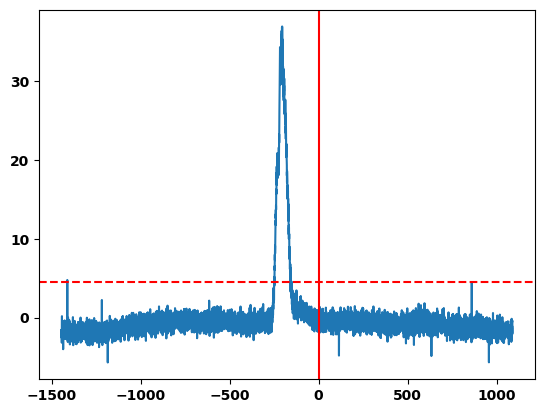

In [277]:
vels,spec=Processor(data[2],data[3],data[5],data[6],data[1])
print(len(vels))
plt.plot(vels,spec)
#plt.xlim(0,100)
plt.axvline(x=0,ymax=40,color='r')
plt.axhline(y=np.mean(spec)+1*np.std(spec),color='r',ls='--')
#print(find_peaks(np.abs(spec),height=20,width=[0,1]))
#plt.vlines([freq[el] for el in find_peaks(np.abs(spec),threshold=1*np.std(spec),width=[0,10])[0]],ymin=-50,ymax=100,zorder=10,color='r')

In [220]:
#Initial threshold testing
threshold=np.mean(spec)+1*np.std(spec)
possibles=[]
for num,val in enumerate(spec[1:]):
    if val<threshold and spec[num-1]>threshold:
        possibles.append(np.mean([vels[num-1],vels[num]]))
print(np.max(possibles))
print(V_max_finder(vels,spec))

-152.00860396268126
-152.00860396268126


In [271]:
#Actual results
R_list=[]
V_list=[]
for file in spec_list:
    #print(file)
    l,LSR_Corr,OnFreq,On,OffFreq,Off,Cal= Opener(file)
    vels,filtered_spec =Processor(OnFreq,On,Off,Cal,LSR_Corr)
    v_max=V_max_finder(vels,filtered_spec,thres=2)
    #Plots saved for diagnosis of issues and ensuring correct 
    plt.plot(vels,filtered_spec)#plots spec
    plt.axhline(y=np.mean(filtered_spec)+2*np.std(filtered_spec),xmin=np.min(vels),xmax=np.max(vels),color='r',ls='--')#These two lines check determination
    plt.axvline(x=v_max,ymin=np.min(filtered_spec),ymax=np.max(filtered_spec),color='r',ls='--')
    plt.title(f'l = {l} degrees')#Helpful for recognising plots
    plt.grid(True)
    number=file.split('\\')[-1].split('.')[0]
    plt.savefig(f'C:/Users/gjc10/Desktop/GalData/test_plots/{number}.png')
    plt.close()
    r,v=Results_finder(l,v_max,LSR_Corr)
    R_list.append(r)
    V_list.append(v)


In [272]:
def Poly(x,a,b,c,d,e,f,g):#Polynomial to fit to results, purely for smoothing, no physical interpretation
    return a+b*x+c*(x**2)+d*(x**3)+e*(x**4)+f*(x**5)+g*(x**6)
popt1,pcov1=curve_fit(Poly,R_list,V_list)
R_space=np.linspace(np.min(R_list),np.max(R_list),1000)

Text(0, 0.5, 'V(r) (km/s)')

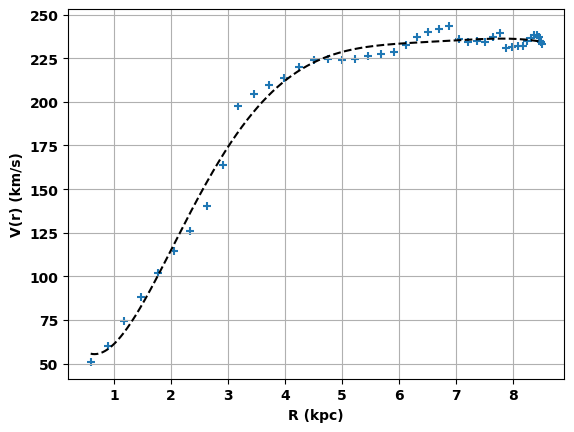

In [273]:
plt.scatter(R_list,V_list,marker='+')
plt.plot(R_space,Poly(R_space,popt1[0],popt1[1],popt1[2],popt1[3],popt1[4],popt1[5],popt1[6]),color='black',ls='--')
plt.grid(True)
plt.xlabel('R (kpc)')
plt.ylabel('V(r) (km/s)')